## Import 

In [1]:
from pathlib import Path
import sys
import os

ROOT_DIR = Path().resolve().parent
sys.path.append(str(ROOT_DIR))

#from sqlalchemy import create_engine
#from sqlalchemy import text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
#from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import joblib
from scripts.features_utils import get_data

## Pull the data
Take the same aggregation level than the previous model, passengers of one route aggregated by service date.

In [2]:
# pull the data. the aggregation data is per day
data = get_data()

if data is None:
    #there was an error fetching the data. exiting
    sys.exit("Couldn't open data from database or file. Aborting.")

In [3]:
# explore the data
data.head()

,corridor_name,train_year,train_week_num,train_departure_date_short,passengers,number_of_services,revenue,revenue_without_promotion,passengers_km,day_category,price_mix_ratio,tickets_saudi,tickets_egyptian,tickets_pakistani,tickets_indian,tickets_yemeni,tickets_indonesian,tickets_jordanian,tickets_USA,tickets_britain
0,MAK-MAD,2021,53,2022-01-01,2579,12,419576.00,451077.0000,960687.672,Christmas,1.12900348972469949593,1312,156,56,84,51,13,41,108,24
1,MAK-MAD,2022,1,2022-01-02,2038,12,343511.50,374778.0000,771785.126,Christmas,1.12644749754661432777,882,112,40,59,51,15,55,58,34
2,MAK-MAD,2022,1,2022-01-03,1900,12,320459.00,345114.5000,730788.374,Christmas,1.14226315789473684211,981,97,40,39,58,10,59,65,36
3,MAK-MAD,2022,1,2022-01-04,1810,12,306953.00,329255.0000,674187.758,Christmas,1.17303867403314917127,1089,85,46,40,34,4,14,45,41
4,MAK-MAD,2022,1,2022-01-05,2440,14,395531.00,422114.0000,936571.790,Christmas,1.14508196721311475410,1405,121,70,40,71,19,12,99,48


## Plot the original data

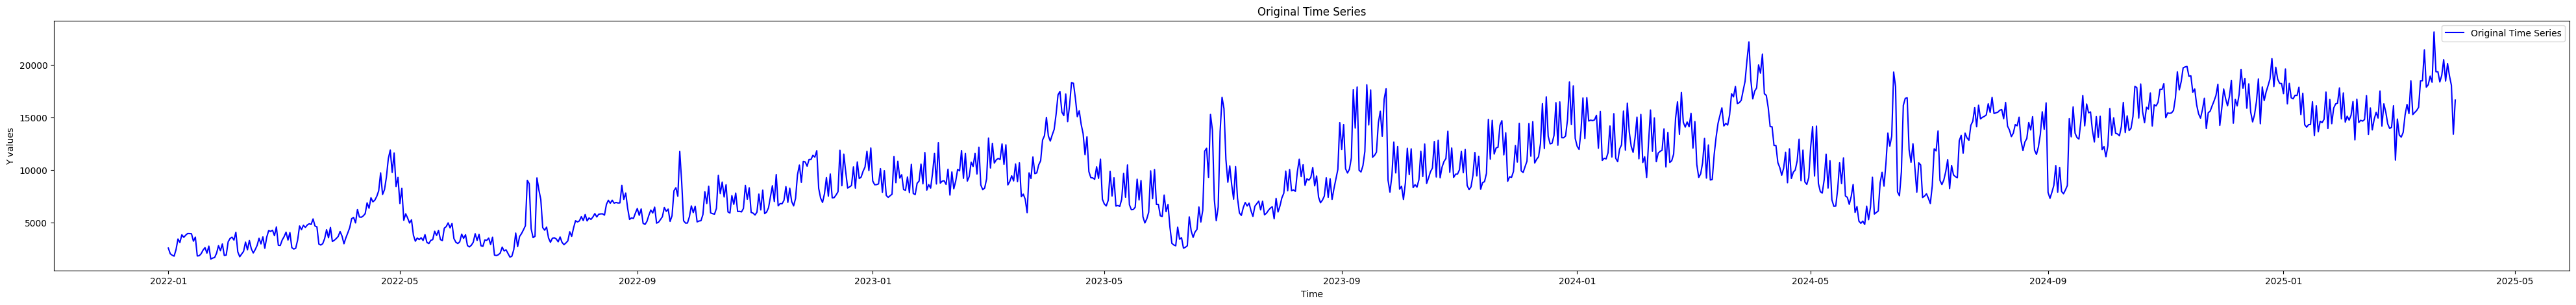

In [4]:
# load data
data.sort_values('train_departure_date_short', inplace=True)
ts_r1 = data["passengers"][data["corridor_name"]=="MAK-MAD"].astype(int)
days = pd.to_datetime(data["train_departure_date_short"][data["corridor_name"]=="MAK-MAD"])

#time = np.arange(ts.shape[0])
#time = range(len(ts_r1))

# Convert to DataFrame
df_r1 = pd.DataFrame({"date": days, "Y": ts_r1})
df_r1.set_index("date", inplace=True)
df_r1.sort_index(inplace=True)

# Plot the original time series
plt.figure(figsize=(50, 5))
plt.plot(df_r1["Y"], label="Original Time Series", color="blue")
plt.xlabel("Time")
plt.ylabel("Y values")
plt.title("Original Time Series")
plt.legend()
plt.show()


## Split the data
Same as previous models, to compare. 80% of the data for training.

In [5]:
# Split between training and test
n = len(df_r1)
train_size = int(n * 0.8)
test_size = n - train_size

y_train = df_r1['Y'][:train_size]
y_test = df_r1['Y'][train_size:]

## Holt Winters
Initially, the Holt Winter alone is tried with different set ups. It seems that the additive model works better than the multiplicative.<br>
The parameters are being estimated by the model, but those don't converge. The use of boxcox help to find the parameters, but later on have worst performance.<br>
It seems that the model fail to capture essential aspects of the demand, information not present in the time variable itself.

In [6]:
holt_winters_fit_params = {
    #'smoothing_level': 0.36,
   #'smoothing_trend': 0.0001,
    #'smoothing_seasonal': 0,
    'optimized': True,
    'use_brute': True
}

holt_winters_add_params = {
    'trend':'add',
    'seasonal':'add',
    'seasonal_periods':357,
    'initialization_method':'estimated',
    #'freq':'D',
    #'use_boxcox':True
    'damped_trend':True
}

holt_winters_mult_params = {
    'trend':'add',
    'seasonal':'mul',
    'seasonal_periods':357,
    'initialization_method':'estimated',
    #'freq':'D',
    #'use_boxcox':True
    'damped_trend':True
}

In [7]:
# multiplicative triple model
model_mul = ExponentialSmoothing(y_train,**holt_winters_mult_params)
fit_mul = model_mul.fit(**holt_winters_fit_params)
forecast_mult = fit_mul.forecast(test_size)

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [8]:
# additive triple model
model_add = ExponentialSmoothing(y_train,**holt_winters_add_params)
fit_add = model_add.fit(**holt_winters_fit_params)
forecast_add = fit_add.forecast(test_size)

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


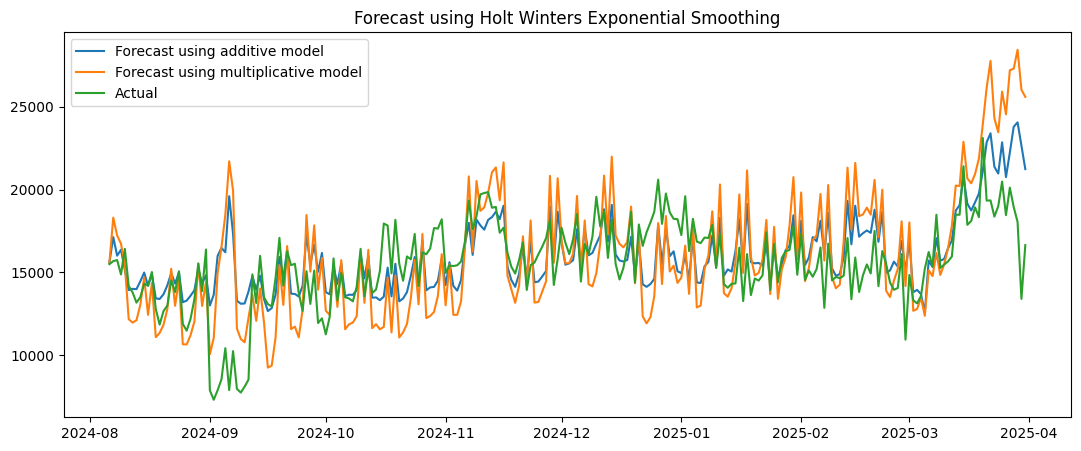

In [9]:
plt.figure(figsize = (13,5))
plt.plot(y_test.index, forecast_add, label='Forecast using additive model')
plt.plot(y_test.index, forecast_mult, label='Forecast using multiplicative model')
plt.plot(y_test.index, y_test, label='Actual')
plt.legend()
plt.title("Forecast using Holt Winters Exponential Smoothing")
plt.show()

## Evaluation

In [10]:
# forecasting
y_pred = forecast_add

# evaluation
print("R² Score:", r2_score(y_test, y_pred)) 
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R² Score: 0.17804939909135753
Mean Absolute Error: 1657.469366680734
Mean Squared Error: 5497658.788492937


## Prices adjustment
Similarly to previous models, we are gonna try to help the model deal with the different offers unrelated between them.<br>
Since Holt Winters does not accept exogeneous variables, the approach will be to train the model with the adjusted passengers (the calculated passengers that the service would have in case of no price modification), and later on forecast the residual using a model with the price ratio.

In [11]:
# calculate the price ratio
df_prices = pd.DataFrame()
df_prices['price_ratio'] = data['revenue'] / data['revenue_without_promotion']
df_prices.index = data['train_departure_date_short']
df_prices = df_prices.join(df_r1[['Y']], how='left')

In [12]:
# estimation of price elasticity
# log-log
X = np.log(df_prices['price_ratio'].astype(float))
y = np.log(df_prices['Y'].astype(float))

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 24 May 2025   Prob (F-statistic):                nan
Time:                        11:50:07   Log-Likelihood:                    nan
No. Observations:                1186   AIC:                               nan
Df Residuals:                    1184   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const              nan        nan        nan      

In [13]:
# get the adjusted passengers and use it to train the model again
elasticity = float(-.6754)
df_prices['Y_adjusted'] = df_prices['Y'].astype(float) * (1/(df_prices['price_ratio'].astype(float) ** elasticity))

Repeat the training with the new variable

In [14]:
# Split between training and test
n = len(df_prices)
train_size = int(n * 0.8)
test_size = n - train_size

y_train = df_prices['Y_adjusted'][:train_size]
y_test = df_prices['Y_adjusted'][train_size:]

In [15]:
# multiplicative triple model
model_mul_adj = ExponentialSmoothing(y_train,**holt_winters_mult_params)
fit_mul_adj = model_mul_adj.fit(**holt_winters_fit_params)
forecast_mult_adj = fit_mul_adj.forecast(test_size)

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ValueError: endog must be strictly positive when usingmultiplicative trend or seasonal components.

In [ ]:
# additive triple model
model_add_adj = ExponentialSmoothing(y_train,**holt_winters_add_params, use_boxcox=True)
fit_add_adj = model_add_adj.fit(**holt_winters_fit_params)
forecast_add_adj = fit_add_adj.forecast(test_size)

In [ ]:
plt.figure(figsize = (13,5))
plt.plot(y_test.index, forecast_add_adj, label='Forecast using additive model')
plt.plot(y_test.index, forecast_mult_adj, label='Forecast using multiplicative model')
plt.plot(y_test.index, y_test, label='Actual')
plt.legend()
plt.title("Forecast using Holt Winters Exponential Smoothing")
plt.show()

In [ ]:
# forecasting
y_pred = forecast_add_adj

# evaluation
print("R² Score:", r2_score(y_test, y_pred)) 
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

## Residual Model
The previous score is fine, but this is predicting the base passenger, not the real ones. <br>
In order to predict the real passengers, taken in consideration the prices, a new prediction will be done to forecast the residuals of the holt winters model against the real passengers, using the price_ratio.<br>
After analyzing different options, none threw a satisfactory result, discarding the idea.<br>

In [ ]:
# calculate the residuals of the training part of the holt winters model
fitted_values_adj = fit_add_adj.fittedvalues

#df_prices['residuals'] = df_prices['Y'] - fitted_values_adj
#df_prices['log_price_ratio'] = np.log(df_prices['price_ratio'].astype(float))
#df_prices['log_residuals'] = np.log(df_prices['residuals'].astype(float))
#df_prices['sqr_price_ratio'] = np.square(df_prices['price_ratio'].astype(float))
df_prices['log_ratio_adjustment'] = np.log((df_prices['Y'] / fitted_values_adj).astype(float))
df_prices_clean = df_prices.dropna()

In [ ]:
# create the model for the residuals
X = np.asarray(df_prices_clean['price_ratio'].astype(float))
y = np.asarray(df_prices_clean['log_ratio_adjustment'].astype(float))

X = sm.add_constant(X)
model_residuals = sm.OLS(y, X).fit()
print(model_residuals.summary())

In [ ]:
# predict the residuals using the new model
X_test = df_prices[['price_ratio']][-test_size:].astype(float)
X_test = sm.add_constant(X_test)

ratio_predicted = np.exp(model_residuals.predict(X_test))


final_forecast = forecast_add_adj * ratio_predicted

In [ ]:
# evaluation of the combination of holt winters + residuals model against the real passengers
y_pred = final_forecast
y_test = df_prices['Y'][-test_size:]

# evaluation
print("R² Score:", r2_score(y_test, y_pred)) 
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

In [ ]:
fig, axs = plt.subplots(2, sharex=True, figsize=(30, 6))
fig.suptitle('Forecast using Holt Winters Exponential Smoothing')

axs[0].plot(y_test.index, y_pred, label='Forecast using additive model and residual adjust due to prices')
axs[0].plot(y_test.index, forecast_add_adj, label='Original Forecast')
axs[0].plot(y_test.index, y_test, label='Actual')
axs[0].legend()



axs[1].plot(y_test.index, ratio_predicted, label='Ratio Predicted')
axs[1].plot(y_test.index, df_prices[['price_ratio']][-test_size:].astype(float), label='Price Ratio')
axs[1].legend()

plt.show()

## Export
After checking the adjustment did not work, it is better not revert to the original model, even though it fails to explain the variation of the real data. Mostly, the error appears because two reasons:
* Multiple calendars / seasonalities: There are two seasonalities affecting the outcome, at different days lags, according to the gregorian calendar and the hijjri calendar. Some periods are influenced by one, while others are influenced by the later, make difficult to be learnt by such a simple model. (i.e. the change of the year is christmas vacations, that the model did not catch, affected by the gregorian. Similarly, if we choose the gregorian lag then the ramadan period (march of 2025 in the test set) will not be properly modeled.)
* Adjustment of prices: variations in price affect the outcome, completely unrelated to time (it is not always in the same periods. for example, all the end 2024 was promoted except for two weeks in the beginning of septemeber, while in 2023 only september was promoted)

In [ ]:
joblib.dump(fit_add, os.path.join(ROOT_DIR, "models", "final_model_holt_winters.pkl"))
# To load later
# model = joblib.load("final_model_holt_winters.pkl")

In [ ]:
fit_add.forecast(steps=100)

In [ ]:
data["train_departure_date_short"].dtype